In [25]:
import random
from collections import defaultdict
import time
import matplotlib.pyplot as plt
from functools import cache
import numpy as np
from sage.matroids.advanced import *
import bisect

# Random Matroid Generation

In [28]:
class RandomMatroid:
    def __init__(self, n, k=0):
        self.n = n
        if k == 0:
            self.k = random.randint(1, n)
        else:
            self.k = k
    
    # If not overriden, returns a random k-uniform matroid, where k is also uniform
    # between 1 and the universe size
    def rand_matroid(self):
        return matroids.Uniform(self.k, self.n)
    
    def gen(self, num_matroids):
        for _ in range(num_matroids):
            yield self.rand_matroid()

In [22]:
class GraphicRandomMatroid(RandomMatroid):
    def __init__(self, n, default=True):
        super().__init__(n)
        self.default = default
        
    def rand_matroid(self):
        if self.default:
            G = graphs.RandomGNM(random.randint(math.ceil((1+math.sqrt(1+8*self.n))/2), self.n), self.n)
        else:
            G = graphs.RandomGNM(random.randint(self.n, self.n * 2), self.n)
        edges = [(e[0], e[1], i) for i, e in enumerate(G.edges())]
        return Matroid(graph=edges)

In [4]:
class LinearRandomMatroid(RandomMatroid):
    # Dependence probability p refers to the probability that a newly generated element will be 
    # independent from all previous elements. If the element isn't independent from all previous 
    # elements, then it will be chosen to be a random integer linear combination of a uniform 
    # subset of the previously generated elements
    #
    # All linear matroids will be over a finite field of the given order. To simulate real numbers,
    # make the order big compared to n
    def __init__(self, n, order=100, p=[0, 1]):
        super().__init__(n)
        self.order = order
        self.p = p
    
    # return one random linear matroid
    def rand_matroid(self):
        p = random.uniform(*self.p)
        first_vector = [random.randint(0, self.order - 1) for j in range(self.n)]
        matrix = [first_vector]
        for i in range(1, self.n):
            if random.random() < p:
                # generate a uniform random subset of [1, ..., i - 1]
                index_set = []
                for j in range(i):
                    if random.random() < 0.5: index_set.append(j)
                        
                if len(index_set) == 0: vector = [random.randint(0, self.order - 1) for j in range(self.n)]
                else:
                    vector = np.array([0 for j in range(self.n)])
                    for j in index_set:
                        coef = random.randint(1, self.order - 1)
                        to_add = np.array(matrix[j])
                        vector += to_add * coef
                        vector = vector % self.order
                        
                    vector = list(vector)
                        
            else: 
                vector = [random.randint(0, self.order - 1) for j in range(self.n)]
                
            matrix.append(vector)

        l = LinearMatroid(Matrix(GF(self.order), self.n, self.n, matrix).transpose())
        if verbose: print(l.rank())
        return l

In [5]:
class TransversalMatroid:
    # a = Number of nodes on the left side, a = number of nodes on the right side
    # p = likelihood of a certain edge from some vertex on left to some vertex on right appearing
    def __init__(self, a, b, p):
        self.a = a; self.b = b; self.p = p
        
        self.A = [i for i in range(0, self.a)]
        self.B = [i for i in range(self.a, self.a + self.b)]
        self.source = -1
        self.sink = self.a + self.b
        self.adjacency = {vertex: [] for vertex in range(self.sink + 1)}
        self.adjacency[self.source] = [x for x in self.A]
        
        # Initialize flow-network that will be used to check if perfect matchings exist
        for v2 in self.B: self.adjacency[v2].append(self.sink)
        
        for v1 in self.A:
            for v2 in self.B:
                if random.random() < p: self.adjacency[v1].append(v2)
                    
        self.G = DiGraph(self.adjacency)
        #self.G.plot().show()
        
        for edge in self.G.edge_boundary(self.A):
            u = edge[0]; v = edge[1]
            self.G.set_edge_label(u, v, 1)
            
        for edge in self.G.edge_boundary(self.B):
            u = edge[0]; v = edge[1]
            self.G.set_edge_label(u, v, 1)
            
        self.n = a

    # Important: to make use of the cache, s needs to be immutable, e.g. a frozenset
    @cache
    def is_independent(self, s):
        for edge in self.G.edge_boundary([self.source]):
            u = edge[0]; v = edge[1]
            self.G.set_edge_label(u, v, 1 if v in s else 0)
        
        flow = self.G.flow(self.source, self.sink, use_edge_labels=True)
        assert flow <= len(s)
        return flow == len(s)
    
    # Finds a max-weight basis of X (that is a subset of 0, ..., n - 1)
    # weights should be a dictionary with key in X and value equivalent to weight of key
    def max_weight_independent(self, X=None, weights=None):
        # Use the greedy algorithm
        order = sorted(X, key=lambda item: weights[item], reverse=True)
        
        current = set()
        for e in order:
            current.add(e)
            if not self.is_independent(frozenset(current)):
                current.remove(e)

        return current
    
    # Return the span of X
    def closure(self, X):
        basis = self.max_weight_independent(X, {x: 0 for x in X})
        
        span = set()
        for i in range(self.n):
            if i in basis: span.add(i)
            else:
                basis.add(i)
                if not self.is_independent(frozenset(basis)): span.add(i)
                basis.remove(i)
                
        return span
    
    def size(self):
        return self.n

In [6]:
class TransversalRandomMatroid(RandomMatroid):
    # a = Number of nodes on the left side, a = number of nodes on the right side
    # p = likelihood of a certain edge from some vertex on left to some vertex on right appearing
    def __init__(self, a=10, b=10, p=0.5):
        super().__init__(a)
        self.a = a
        self.b = b
        self.p = p
    
    # return one random transversal matroid
    def rand_matroid(self):
        return TransversalMatroid(self.a, self.b, self.p)

In [7]:
class GeneralRandomMatroid(RandomMatroid):
    def __init__(self, n):
        super().__init__(n)
        self.U = frozenset(range(n))
    
    def _isContained(self, AandB, Fr):
        if len(AandB) == 0: return True
        for C in Fr:
            if AandB.issubset(C): return True
        return False
    
    def rand_matroid(self):
        r = 0
        F = [set(frozenset())]
        while self.U not in F[r]:
            # generate covers
            F_next = set(frozenset())
            if r == 0:
                for a in self.U:
                    F_next.add(frozenset([a]))
            else:
                for A in F[r]:
                    for a in self.U - A:
                        x = set(A)
                        x.add(a)
                        F_next.add(frozenset(x))

            #enlarge
            if r != 0:
                # adjust the number of times this loop is performed to generate different matroids
                for _ in range(random.randint(0, self.n//2)):
                    A = set(random.choice(list(F_next)))
                    F_next.remove(A)
                    if len(list(self.U-A)) != 0:
                        A.add(random.choice(list(self.U-A)))
                    F_next.add(frozenset(A))

            # superpose
            isContained = False
            while not isContained:
                isContained = True
                not_contained = []
                for A in F_next:
                    for B in F_next:
                        if A == B: continue
                        if not self._isContained(A.intersection(B), F[r]): 
                            not_contained.append((A, B))
                            isContained = False
                for AB in not_contained:
                    A, B = AB
                    if A in F_next and B in F_next:
                        F_next.remove(A)
                        F_next.remove(B)
                        F_next.add(A.union(B))
            F.append(F_next)
            r += 1
    
        closed_sets = []
        for rank, X in enumerate(F):
            for Y in X:
                closed_sets.append((rank, Y))

        return Matroid(self.U, circuit_closures = closed_sets)

# Test Suite for Naive Virtual Algorithm

## Algorithm Implementation

In [8]:
# Import any algorithm implementations here
class FreeOrderMatroidAlgo:
    def __init__(self, matroid, weights):
        assert matroid.size() == len(weights)

        self.matroid = matroid
        self.weights = weights

class Conjecture(FreeOrderMatroidAlgo):
    def __init__(self, matroid, weights, sample_prob, verbose=False):
        super().__init__(matroid, weights)
        self.verbose = verbose
        
        # Sample S
        S = []
        self.P = set()
        for i in range(self.matroid.size()):
            if random.random() < sample_prob: 
                S.append((i, self.weights[i]))
            else: self.P.add(i)
                
        self.top_k = sorted([(weight_i, True) for i, weight_i in S])

        self.P = frozenset(self.P)
        S = dict(S)
        if self.verbose: print(f'{S = }')
        self.X = self.matroid.max_weight_independent(X=set(S.keys()), weights=S) # max-weight basis of S
        self.X = sorted(list(self.X), key=lambda i: self.weights[i], reverse=True)
        
        self.k = self.matroid.rank()

    def run_trial(self):
        cache(self.matroid.is_independent)
        
        total = 0
        remaining = set(self.P) # which elements haven't been seen yet
        A = frozenset() # store the answer

        Xset = set()
        for i, basis_elem in enumerate(self.X):
            # Check which elements in remaining are dependent
            Xset.add(basis_elem)
            candidates = []
            for element in remaining:
                Xset.add(element)
                if not self.matroid.is_independent(frozenset(Xset)): candidates.append(element)
                Xset.remove(element)
            random.shuffle(candidates)
            
            if self.verbose: print(f'{candidates = }')
            for y in candidates:
                remaining.remove(y)
                
                top_i_weight, top_i_from_sample = self.top_k[len(self.top_k) - i - 1]
                
                if (self.weights[y] > top_i_weight) and (top_i_from_sample):
                    if self.matroid.is_independent(A.union(frozenset([y]))): 
                        A = A.union(frozenset([y]))
                        total += self.weights[y]
                        if self.verbose: print(f'{y = }')
                    
                bisect.insort(self.top_k, (self.weights[y], False))

        remaining = list(remaining)
        if self.verbose: print(f'{remaining = }')
        random.shuffle(remaining)
        for y in remaining:
            
            if len(self.top_k) >= self.k:
                top_k_weight, top_k_from_sample = self.top_k[len(self.top_k) - self.k]
                
                if not top_k_from_sample:
                    bisect.insort(self.top_k, (self.weights[y], False))
                    continue
                
            if self.matroid.is_independent(A.union(frozenset([y]))): 
                A = A.union(frozenset([y]))
                total += self.weights[y]
            
            bisect.insort(self.top_k, (self.weights[y], False))

        return total, A

## Experiment Setup

In [9]:
# algo is assumed to be a FreeOrderMatroidAlgo. Returns averaged payoff over all trials
# weights will be a list of values of each item
def run_trials(num_trials, matroid, weights, verbose = False):
    sum = 0
    total_counts = defaultdict(lambda: 0)
    for _ in range(num_trials):
        algo = Conjecture(matroid, weights, exp(-1), verbose)
        weight, included = algo.run_trial()
        sum += weight
        if verbose: print(f'{included = }')
        for element in included: total_counts[element] += 1

    for key in total_counts: total_counts[key] = float(total_counts[key]) / num_trials
    return float(sum / num_trials), total_counts

In [10]:
def run_experiment(M, num_trials, weights = None, verbose = False):
    if weights is None: weights = [random.uniform(0, 1) for i in range(M.size())]

    start_time = time.time()
    val, freqs = run_trials(num_trials, M, weights, verbose)
    end_time = time.time()
    
    if verbose: print(f"Time to run {num_trials} trials is ", end_time - start_time)

    opt_indices = M.max_weight_independent(X=set(range(M.size())), weights = dict([(i, weight) for i, weight in enumerate(weights)]))
    opt_val = 0
    ratios = []
    
    for opt_index in opt_indices:
        ratios.append(freqs[opt_index])
        #if (freqs[opt_index] < exp(-1)):
            #print("Less than 1/e when ", M, opt_index)

    if verbose: print(ratios)
    return min(ratios)

In [11]:
def evaluate(rand_matroid, num_matroids, num_trials):
    results = []
    for i, M in enumerate(rand_matroid.gen(num_matroids), 1):
        start = time.time()
        results.append(run_experiment(M, num_trials))
        end = time.time()
        print(f'Matroid {i}/{num_matroids} completed in {round(end - start, 2)}s')
    return results

In [48]:
def plot(results, fname=None):
    bins = []
    for x in range(int(min(results)/((1/30)*float(exp(-1)))), int(max(results)/((1/30)*float(exp(-1))))+1):
        bins.append(x*(1/30)*float(exp(-1)))
    plt.hist(results, bins = bins, density=True)
    plt.axvline(x=float(exp(-1)), color = 'r', linestyle='dashed')
    plt.xlabel('Minimum Ratio of Optimal Secretaries', fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.tight_layout()
    if fname: plt.savefig(fname)
    plt.show()

## Evaluation of Algorithm

In [13]:
# Experiment 1: 100 graphic matroids, size 101
random.seed(int(1001))
results1 = evaluate(GraphicRandomMatroid(n=101), num_matroids=10, num_trials=1000)

Matroid 1/10 completed in 25.14s
Matroid 2/10 completed in 65.61s
Matroid 3/10 completed in 56.59s
Matroid 4/10 completed in 41.08s
Matroid 5/10 completed in 52.04s
Matroid 6/10 completed in 63.17s
Matroid 7/10 completed in 63.62s
Matroid 8/10 completed in 52.6s
Matroid 9/10 completed in 57.32s
Matroid 10/10 completed in 39.48s


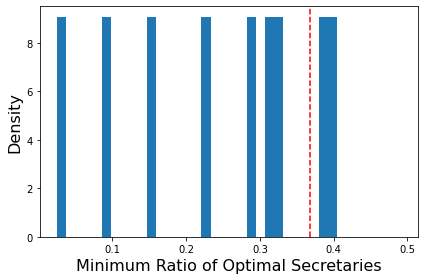

[0.097, 0.493, 0.309, 0.156, 0.23, 0.324, 0.383, 0.288, 0.401, 0.036]


In [50]:
plot(results1)
print(results1)

In [20]:
# Experiment 1: 100 graphic matroids, size 101
random.seed(int(1001))
results1_1 = evaluate(GraphicRandomMatroid(n=101, default=False), num_matroids=10, num_trials=1000)

Matroid 1/10 completed in 57.07s
Matroid 2/10 completed in 62.3s
Matroid 3/10 completed in 52.21s
Matroid 4/10 completed in 61.38s
Matroid 5/10 completed in 51.88s
Matroid 6/10 completed in 56.63s
Matroid 7/10 completed in 59.07s
Matroid 8/10 completed in 57.99s
Matroid 9/10 completed in 57.89s
Matroid 10/10 completed in 61.64s


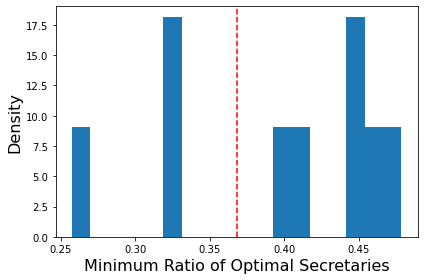

[0.482, 0.45, 0.331, 0.449, 0.266, 0.328, 0.406, 0.465, 0.399, 0.475]


In [49]:
plot(results1_1)
print(results1_1)

In [23]:
# Experiment 1: 100 graphic matroids, size 101
random.seed(int(1001))
results1_2 = evaluate(GraphicRandomMatroid(n=101, default=False), num_matroids=10, num_trials=1000)

Matroid 1/10 completed in 61.0s
Matroid 2/10 completed in 58.24s
Matroid 3/10 completed in 63.08s
Matroid 4/10 completed in 62.65s
Matroid 5/10 completed in 62.42s
Matroid 6/10 completed in 59.42s
Matroid 7/10 completed in 62.49s
Matroid 8/10 completed in 59.94s
Matroid 9/10 completed in 59.62s
Matroid 10/10 completed in 59.41s


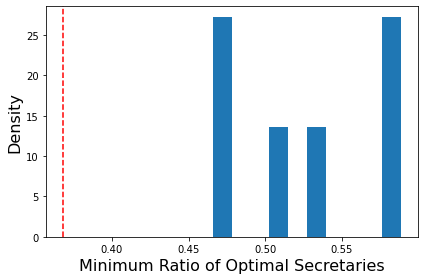

[0.595, 0.595, 0.598, 0.588, 0.589, 0.58, 0.537, 0.467, 0.507, 0.467]


In [51]:
plot(results1_2)
print(results1_2)

In [36]:
# Experiment 7: 100 Random Uniform Matroids with universe size = 100 (rank is 3)
random.seed(int(1007))
results7 = evaluate(RandomMatroid(100, k=3), num_matroids=100, num_trials=1000)

Matroid 1/100 completed in 14.99s
Matroid 2/100 completed in 14.63s
Matroid 3/100 completed in 15.11s
Matroid 4/100 completed in 12.67s
Matroid 5/100 completed in 12.8s
Matroid 6/100 completed in 15.1s
Matroid 7/100 completed in 13.95s
Matroid 8/100 completed in 14.07s
Matroid 9/100 completed in 12.66s
Matroid 10/100 completed in 12.32s
Matroid 11/100 completed in 13.07s
Matroid 12/100 completed in 13.58s
Matroid 13/100 completed in 13.72s
Matroid 14/100 completed in 13.36s
Matroid 15/100 completed in 12.94s
Matroid 16/100 completed in 12.66s
Matroid 17/100 completed in 13.07s
Matroid 18/100 completed in 12.14s
Matroid 19/100 completed in 12.03s
Matroid 20/100 completed in 11.98s
Matroid 21/100 completed in 13.12s
Matroid 22/100 completed in 12.11s
Matroid 23/100 completed in 12.19s
Matroid 24/100 completed in 12.12s
Matroid 25/100 completed in 12.14s
Matroid 26/100 completed in 12.36s
Matroid 27/100 completed in 12.11s
Matroid 28/100 completed in 12.1s
Matroid 29/100 completed in 12.1

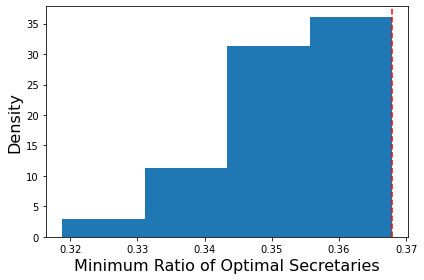

[0.364, 0.363, 0.35, 0.35, 0.345, 0.361, 0.358, 0.357, 0.366, 0.344, 0.352, 0.351, 0.368, 0.37, 0.364, 0.342, 0.38, 0.351, 0.365, 0.356, 0.371, 0.358, 0.34, 0.376, 0.36, 0.361, 0.371, 0.357, 0.36, 0.366, 0.365, 0.347, 0.342, 0.361, 0.361, 0.369, 0.351, 0.346, 0.352, 0.352, 0.356, 0.339, 0.349, 0.345, 0.339, 0.374, 0.337, 0.361, 0.345, 0.35, 0.347, 0.36, 0.352, 0.358, 0.37, 0.348, 0.364, 0.364, 0.353, 0.342, 0.356, 0.322, 0.341, 0.341, 0.341, 0.357, 0.355, 0.339, 0.374, 0.37, 0.366, 0.366, 0.365, 0.331, 0.365, 0.35, 0.355, 0.359, 0.377, 0.339, 0.35, 0.369, 0.357, 0.35, 0.359, 0.353, 0.351, 0.357, 0.355, 0.361, 0.345, 0.369, 0.363, 0.323, 0.354, 0.358, 0.352, 0.352, 0.35, 0.365]


In [52]:
plot(results7)
print(results7)

In [40]:
# Experiment 8: 100 Random Uniform Matroids with universe size = 100 (rank is 50)
random.seed(int(1008))
results8 = evaluate(RandomMatroid(100, k=50), num_matroids=100, num_trials=1000)

Matroid 1/100 completed in 20.22s
Matroid 2/100 completed in 19.73s
Matroid 3/100 completed in 17.22s
Matroid 4/100 completed in 16.2s
Matroid 5/100 completed in 18.35s
Matroid 6/100 completed in 16.89s
Matroid 7/100 completed in 15.58s
Matroid 8/100 completed in 15.76s
Matroid 9/100 completed in 16.59s
Matroid 10/100 completed in 17.01s
Matroid 11/100 completed in 16.47s
Matroid 12/100 completed in 16.61s
Matroid 13/100 completed in 17.19s
Matroid 14/100 completed in 16.31s
Matroid 15/100 completed in 17.49s
Matroid 16/100 completed in 17.49s
Matroid 17/100 completed in 16.58s
Matroid 18/100 completed in 16.61s
Matroid 19/100 completed in 16.57s
Matroid 20/100 completed in 15.2s
Matroid 21/100 completed in 19.77s
Matroid 22/100 completed in 16.58s
Matroid 23/100 completed in 16.67s
Matroid 24/100 completed in 16.56s
Matroid 25/100 completed in 15.68s
Matroid 26/100 completed in 15.35s
Matroid 27/100 completed in 15.31s
Matroid 28/100 completed in 15.57s
Matroid 29/100 completed in 15.

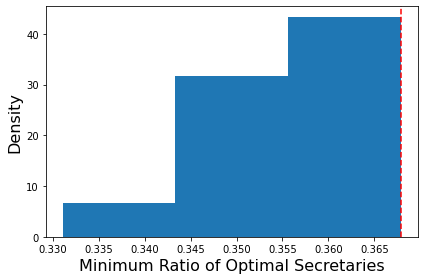

[0.35, 0.347, 0.357, 0.36, 0.359, 0.343, 0.355, 0.369, 0.358, 0.362, 0.36, 0.359, 0.363, 0.35, 0.35, 0.365, 0.359, 0.36, 0.36, 0.361, 0.352, 0.348, 0.36, 0.359, 0.363, 0.356, 0.356, 0.353, 0.355, 0.36, 0.351, 0.356, 0.347, 0.352, 0.363, 0.354, 0.349, 0.359, 0.36, 0.364, 0.36, 0.359, 0.336, 0.357, 0.347, 0.35, 0.357, 0.355, 0.343, 0.34, 0.347, 0.338, 0.365, 0.356, 0.35, 0.357, 0.348, 0.359, 0.346, 0.362, 0.359, 0.363, 0.354, 0.356, 0.351, 0.348, 0.356, 0.35, 0.347, 0.353, 0.355, 0.37, 0.36, 0.359, 0.352, 0.355, 0.356, 0.354, 0.356, 0.339, 0.358, 0.359, 0.356, 0.35, 0.359, 0.349, 0.366, 0.348, 0.36, 0.354, 0.357, 0.367, 0.341, 0.367, 0.365, 0.355, 0.352, 0.34, 0.358, 0.354]


In [53]:
plot(results8)
print(results8)

In [44]:
# Experiment 9: 100 Random Uniform Matroids with universe size = 100 (rank is 90)
random.seed(int(1009))
results9 = evaluate(RandomMatroid(100, k=90), num_matroids=10, num_trials=1000)

Matroid 1/10 completed in 14.58s
Matroid 2/10 completed in 14.45s
Matroid 3/10 completed in 14.51s
Matroid 4/10 completed in 14.73s
Matroid 5/10 completed in 14.73s
Matroid 6/10 completed in 14.45s
Matroid 7/10 completed in 17.77s
Matroid 8/10 completed in 15.73s
Matroid 9/10 completed in 16.21s
Matroid 10/10 completed in 16.05s


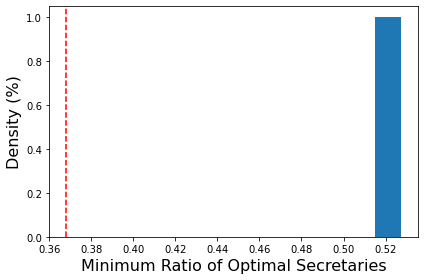

[0.53, 0.539, 0.536, 0.532, 0.53, 0.525, 0.539, 0.531, 0.533, 0.532]


In [45]:
plot(results9)
print(results9)